# Data 

Dataset consists of historic match data for the German Bundesliga (1st and 2nd Division) as well as the English Premier League reaching back as far as 1993 up to 2016. Besides the mere information concerning goals scored and home/draw/away win the dataset also includes per site (team) data such as transfer value per team (pre-season), the squad strength, etc.

## Importing the Libraries

In [1]:
import sqlite3
import pandas as pd
import requests
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading the database of 2011 in Pandas Dataframe

In [2]:
con = sqlite3.connect('database.sqlite')
cur = con.cursor()
Matches = pd.DataFrame(data = cur.execute('select * from Matches where Season = 2011').fetchall(), columns=[x[0] for x in cur.description])
Teams = pd.DataFrame(data = cur.execute('select * from Teams where Season = 2011').fetchall(), columns=[x[0] for x in cur.description])
unique_teams = pd.DataFrame(data = cur.execute('select * from Unique_Teams').fetchall(), columns=[x[0] for x in cur.description])
teams_in_matches = pd.DataFrame(data = cur.execute('select * from Teams_in_Matches').fetchall(), columns=[x[0] for x in cur.description])

# The total number of goals scored by the team during the 2011 season

In [3]:
#Calculating goals scored by Home Team & Away Team
Home_Goals = Matches.groupby('HomeTeam')['FTHG'].sum()
Away_Goals = Matches.groupby('AwayTeam')['FTAG'].sum()

#Adding both and getting toal Goals scored by each team
Goals = pd.DataFrame(data = Away_Goals + Home_Goals).reset_index()
Goals.columns = ['Team', 'Season Goals']
Goals.sort_values('Season Goals', inplace=True)

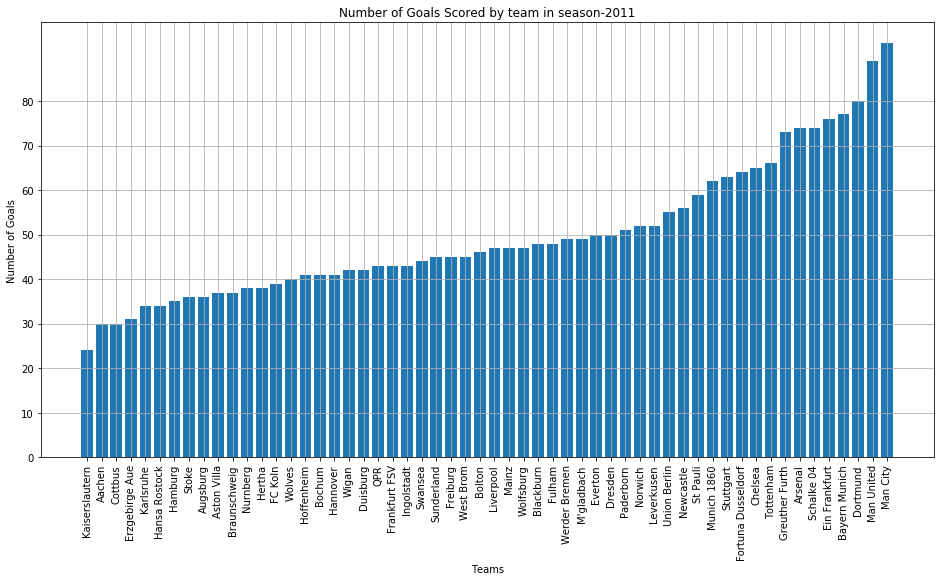

In [4]:
#Plotting the number of goals by team
plt.figure(figsize=(16,8))
plt.bar(Goals['Team'], Goals['Season Goals'])
plt.xticks(rotation=90)
plt.xlabel('Teams')
plt.ylabel('Number of Goals')
plt.title('Number of Goals Scored by team in season-2011')
plt.yticks(range(0,90,10))
plt.grid()
plt.show()

# The total number of wins & losses the team earned during the 2011 season

In [5]:
#Calculating wins team wise when playing away and home
Away_wins = Matches[Matches['FTR'] == 'A']['AwayTeam'].value_counts()
Home_wins = Matches[Matches['FTR'] == 'H']['HomeTeam'].value_counts()
#Creating dataframe to save wins
Wins = pd.DataFrame(data = (Away_wins + Home_wins)).reset_index()
Wins.columns = ['Team', 'Season Wins']

In [6]:
#Calculating losses team wise when playing away and home
Away_losses = Matches[Matches['FTR'] == 'A']['HomeTeam'].value_counts()
Home_losses = Matches[Matches['FTR'] == 'H']['AwayTeam'].value_counts()
Home_wins = Matches[Matches['FTR'] == 'H']['HomeTeam'].value_counts()

#Creating dataframe to save losses
Losses = pd.DataFrame(data = (Away_losses + Home_losses)).reset_index()
Losses.columns = ['Team', 'Season Losses']
Losses['Season Losses'].fillna(0, inplace=True)

# A histogram visualization of the team's wins and losses for the 2011 season

In [7]:
# Merging wins and losses dataframes
Win_Loss = Wins.merge(Losses, how='inner', on = 'Team')
Win_Loss.sort_values('Season Wins', ascending=False, inplace=True)

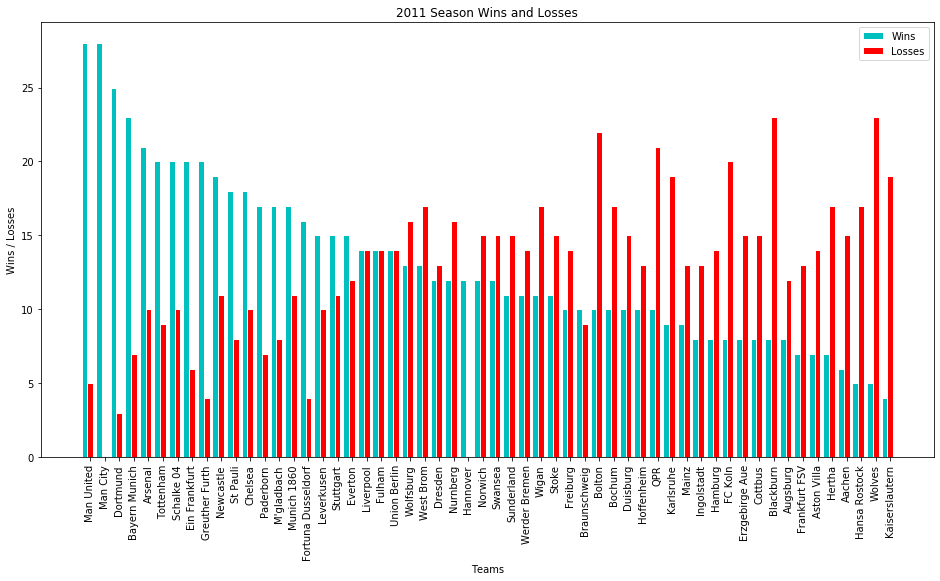

In [8]:
#Plotting wins and losses
plt.figure(figsize=(16,8))
w = 0.4
r1 = range(len(Win_Loss['Team']))
r2 = [x + w for x in r1]
wins = Win_Loss['Season Wins']
losses = Win_Loss['Season Losses']
plt.bar(r1, wins, color='c', width=w, edgecolor='white', label='Wins')
plt.bar(r2, losses, color='r', width=w, edgecolor='white', label='Losses')
plt.xticks(ticks= r2, labels=list(Win_Loss['Team']), rotation=90)
plt.xlabel('Teams')
plt.ylabel('Wins / Losses')
plt.title('2011 Season Wins and Losses')
plt.legend()
plt.show()

# Building the Weather Getter Class

In [9]:
#Initializing class
class weather_getter(object):
    
#Setting lat,long and url for the Dark Sky API 
    def __init__(self,lat, long):
        self.lat = lat
        self.long = long
        self.url = 'https://api.darksky.net/forecast/{}/{},{},{}T17:00:00'
        
#Retreiving the API Key         
    def get_key(self,path='/Users/ravidahiya/.secret/dark_api.json'):
        with open(path) as f:
            keys = json.load(f)
        return keys['api_key']
#Getting weather for one day    
    def weather_day(self, date):
        api_key = self.get_key()
        weather = requests.get(self.url.format(api_key,self.lat,self.long,date))
        f_json = weather.json()
        try:
            weather =  f_json['currently']['summary']
        except:
            try:
                weather = f_json['hourly']['summary']
            except:
                weather = 'no rain'
        return weather
    
#Getting weather for list of dates            
    def weather_list(self, date_list = []):
        weather_dict = {'date': [], 'forecast':[]}
        for date in date_list:
            weather_dict['date'].append(date)
            weather_dict['forecast'].append(self.weather_day(date))
        return weather_dict

# Getting the weather on match days

## 1) For matches in Germany (Assuming weather to be same as weather in Berlin)

In [10]:
# Latitude and longitude of Berlin
lat = 52.5200
long = 13.4050
Matches_Germany = Matches[Matches['Div'].isin(['D2','D1'])]

#Creating instance of weather getter class
weather_germany = weather_getter(lat,long)
#Getting weather on match days
date_weather = weather_germany.weather_list(list(Matches_Germany['Date'].unique()))
date_weather = pd.DataFrame(date_weather)

#Setting forecast for no rain days as 0 and setting as 1 for rain days
date_weather.loc[date_weather['forecast'].isin(['Mostly Cloudy', 'Mostly cloudy throughout the day.',
                                                'Partly Cloudy', 'no rain', 'Foggy overnight and in the morning.',
                                                'Partly cloudy throughout the day.', 'Foggy in the morning.',
                                                'Clear', 'Overcast']),'forecast'] = 0
date_weather.loc[date_weather['forecast'] != 0, 'forecast'] = 1

#Adding forecast column to the matches in Germany
Matches_Germany = Matches_Germany.merge(date_weather,how='left',left_on='Date',right_on='date')

## 2) For matches in England (Assuming weather to be same as weather in London)

In [11]:
#Latitude and Longitude of London
lat = 51.5074
long = 0.1278
Matches_England = Matches[Matches['Div'] == 'E0']

#Creating instance of weather getter class
weather_england = weather_getter(lat,long)
date_weather = weather_england.weather_list(list(Matches_England['Date'].unique()))
date_weather = pd.DataFrame(date_weather)

#Setting forecast for no rain days as 0 and setting as 1 for rain days
date_weather.loc[date_weather['forecast'].isin(['Partly Cloudy','Clear', 
                                                'Mostly Cloudy', 'Foggy', 'Overcast']),'forecast'] = 0
date_weather.loc[date_weather['forecast'] != 0, 'forecast'] = 1

#Adding forecast column to the matches in England
Matches_England = Matches_England.merge(date_weather,how='left',left_on='Date',right_on='date')

# Impact of rain on winnings

In [12]:
#Concatinating the Germany and England league matches to get complete dataset
Matches = pd.concat([Matches_Germany, Matches_England])
Matches.rename(columns={'forecast':'Rain Day'}, inplace=True)
Matches.drop('date',axis=1,inplace=True)

<function matplotlib.pyplot.show(*args, **kw)>

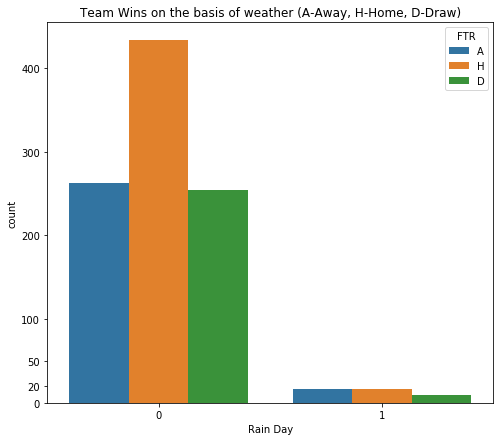

In [13]:
#Impact of rain on the entire season
plt.figure(figsize=(8,7))
sns.countplot(Matches['Rain Day'], hue=Matches['FTR'], orient = 'h')
plt.yticks(ticks=[0,20,50,100,200,300,400])
plt.title('Team Wins on the basis of weather (A-Away, H-Home, D-Draw)')
plt.show

##### As we can see that if there is no rain' chances of Home Team winning is high as compared to when there is rain

## Win Loss percentage Team Wise

In [14]:
Win_Loss['Percent_Win'] = round((Win_Loss['Season Wins']/(Win_Loss['Season Wins']+Win_Loss['Season Losses']))*100,0)

In [15]:
#Calculating winning percentage of teams in 2011 season 
Win_Loss['Percent_Win'] = round((Win_Loss['Season Wins']/(Win_Loss['Season Wins']+
                                                          Win_Loss['Season Losses']))*100,0)
#Filtering out matches with no rain
no_rain = Matches[Matches['Rain Day'] == 0]
#Creating another Dataframe to capture effect of rain on the matches
no_rain_loss = pd.DataFrame(no_rain[no_rain['FTR'] == 'A']['HomeTeam'].value_counts() + 
                            no_rain[no_rain['FTR'] == 'H']['AwayTeam'].value_counts(), columns=['Losses']).fillna(0)
no_rain_win = pd.DataFrame(no_rain[no_rain['FTR'] == 'H']['HomeTeam'].value_counts() + 
                           no_rain[no_rain['FTR'] == 'A']['AwayTeam'].value_counts(), columns=['Wins'])
no_rain_results = no_rain_win.join(no_rain_loss)

#Calculating percentage winning during no rain day
no_rain_results['Percent Win (no_rain)'] = round((no_rain_results['Wins']/(no_rain_results['Wins']+ 
                                                                           no_rain_results['Losses']))*100,0)
no_rain_results.reset_index(inplace=True)
no_rain_results.rename(columns={'index':'Team'},inplace=True)

#Merging tables with and without rain effect
Rain_Effect = Win_Loss.merge(no_rain_results,on='Team')
Rain_Effect['Win %age increase due to rain']  = Rain_Effect['Percent Win (no_rain)'] - Rain_Effect['Percent_Win']
Rain_Effect.sort_values('Win %age increase due to rain', ascending=False,inplace=True)

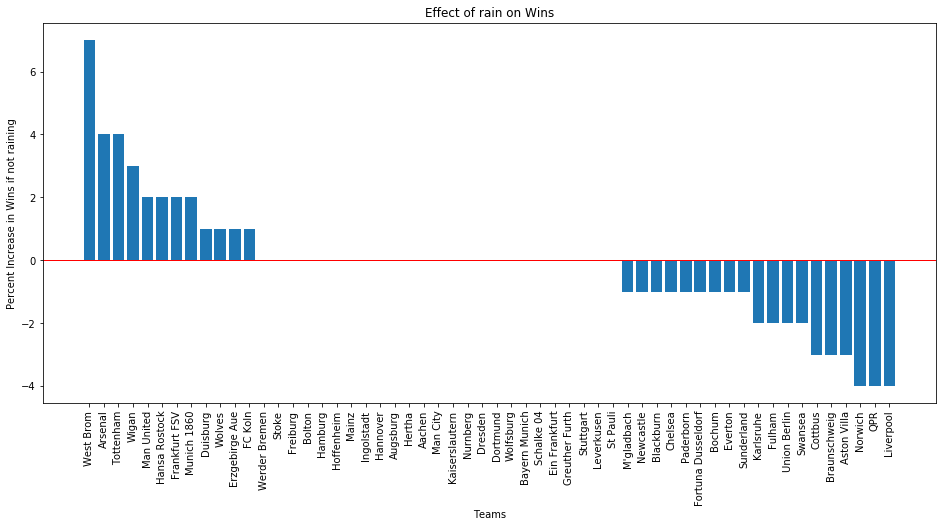

In [16]:
#Plotting effect on winning percentage when it is not raining
plt.figure(figsize=(16,7))
plt.bar(Rain_Effect['Team'],Rain_Effect['Win %age increase due to rain'])
plt.axhline(y=0,linewidth=1, color='r')
plt.xticks(rotation=90)
plt.xlabel('Teams')
plt.ylabel('Percent Increase in Wins if not raining')
plt.title('Effect of rain on Wins')
plt.show()

# Building the Mongo Handler Class

In [17]:
#Importing pymongo anf connecting to the mongo database
import pymongo
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017")
delphi_db = myclient['test']
team_data = delphi_db['team_data']

In [18]:
class MongoHandler(object):
    def __init__(self):
        pass

#Insert 1 document including name, goals scored, wins, losses and bar graph of wins & losses
    def insert_one(self,team=[]):
        self.name = team[0]
        self.goals = team[4]
        self.wins = team[1]
        self.losses = team[2]
        fig = plt.figure()
        plt.bar(x=['Season Wins', 'Season losses'], 
                    height=[self.wins,self.losses])
        plt.savefig('{}.png'.format(self.name))
        plt.close(fig)
        f = open('{}.png'.format(self.name), 'rb')
        data = {'team_name':self.name, 'goals_scored':self.goals, 'Wins':self.wins, 'Losses':self.losses,
               'graph': f.read() 
               }
        team_data.insert_one(data)
        f.close()
        
#Insert many documents at once        
    def insert_many(self,df_list):
        for i in range(len(df_list)):
            team = df_list[i]
            self.insert_one(team)

#Find & return all the documents in the collection
    def find_all(self):
        query = team_data.find({})
        for document in query:
            print(document)
            
#Find and return document as per the key and value
    def find(self, key, value):
        query = team_data.find({key:value})
        for document in query:
            print(document)

In [20]:
#Insert data of all the teams to Mongo DB
Delphi = MongoHandler()
Delphi.insert_many(Rain_Effect.values.tolist())

In [21]:
#Testing the query to retrieve document of Bayern Munich
Delphi.find('team_name','Bayern Munich')

{'_id': ObjectId('5df3a4bb384c1f2c2b53645a'), 'team_name': 'Bayern Munich', 'goals_scored': 77, 'Wins': 23, 'Losses': 7.0, 'graph': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb0\x00\x00\x01 \x08\x06\x00\x00\x00\xd5(&i\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x008tEXtSoftware\x00matplotlib version3.1.1, http://matplotlib.org/\x10f\x17\x19\x00\x00\x11\x9cIDATx\x9c\xed\xdc}L\x95\xf5\xff\xc7\xf1\x17qL\xdbR\xcb\x01\x86i\x10\x83)rwL\x8c\xa1\x85\x18_\xc2\xf1\xdd\xb0b\xa5f\r\xa4\xc9j\xa5\xebf\x95\xad\xd5\xb7\xb2\x1bj\xb5n\xd4\xad\x8eY0u\xd8\xdd\xd2R3\xadEw\x98vTlyK\x16\x89\xc6\x04\x16:-M\xc4\xcf\xef\x8f~\xb2\xaf\x81}\xedF\xae\xeb\x9d\xcf\xc7_py\x1dx\xef\xdaG\x9e\\\x9fs8\x11\xce9\'\x00\x00\x8c9\xcb\xeb\x01\x00\x00\xf83\x08\x18\x00\xc0$\x02\x06\x000\x89\x80\x01\x00L"`\x00\x00\x93\x08\x18\x00\xc0$\x02\x06\x000\x89\x80\x01\x00L"`\x00\x00\x93\x08\x18\x00\xc0$\x02\x06\x000\x89\x80\x01\x00L"`\x00\x00\x93\x08\x18\x